### Import, mount, and configure.

In [ ]:
import os
import sys
import shutil
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from google.colab import files
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

drive.mount('/content/drive')

DRIVE_ROOT = Path('/content/drive/MyDrive')

DATASET_ROOT = DRIVE_ROOT / 'datasets/bitcoin'
DATASET_VERSION = DATASET_ROOT / 'versions'
DATASET_CHECKSUM = DATASET_ROOT / 'checksums'
DATASET_CSV = 'ohlcv_274.csv'
DATASET_TXT = 'ohlcv_274.txt'

PROJECT_ROOT = DRIVE_ROOT / 'projects/bitcoin'
PROJECT_DATA = PROJECT_ROOT / 'data'
PROJECT_RAW = PROJECT_DATA / 'raw'
PROJECT_PROC = PROJECT_DATA / 'processed'
PROJECT_CLEANED = PROJECT_DATA / 'cleaned'
PROJECT_META = PROJECT_DATA / 'metadata'

CSV_RAW = 'bitcoin_274_raw.csv'
CSV_PROC = 'bitcoin_274_proc.csv'
CSV_CLEANED = 'bitcoin_274_cleaned.csv'

dataset_filepath = DATASET_VERSION / DATASET_CSV

raw_filepath = PROJECT_RAW / CSV_RAW
proc_filepath = PROJECT_PROC / CSV_PROC
cleaned_filepath = PROJECT_CLEANED / CSV_CLEANED
checksum_filepath = PROJECT_META / 'checksums.txt'
metadata_filepath = PROJECT_META / 'dataset_versions.md'
gitignore_filepath = PROJECT_ROOT / '.gitignore'

Mounted at /content/drive


In [ ]:
# Add the project root to the system path for custom module discovery.
project_root = os.path.abspath(PROJECT_ROOT)
if project_root not in sys.path:
  sys.path.append(project_root)

In [ ]:
# Import custom functions from custom modules.
from src.data_loader import resample_and_aggregate_dataset
from src.data_splitter import split_dataset

### Save the dataset to Google Drive for persistent storage.

In [ ]:
dataset_filepath = DATASET_VERSION / DATASET_CSV
dataset_filepath.parent.mkdir(parents=True, exist_ok=True)

# Only upload if the file isn't already in Google Drive.
if not dataset_filepath.exists():
  print(f'Dataset not found at {dataset_filepath}.')
  print('Please upload the "bitcoin_274.csv" file.')
  uploaded = files.upload()

  uploaded_filename = list(uploaded.keys())[0]
  shutil.move(uploaded_filename, dataset_filepath)
  print(f'Saved dataset to {dataset_filepath}.')
else:
  print(f'Dataset already exists at {dataset_filepath}.')

Dataset already exists at /content/drive/MyDrive/datasets/bitcoin/versions/ohlcv_274.csv


### Generate checksums for data integrity, version tracking, and debugging.

In [ ]:
# Shell commands do not accept Python variables.
# TODO: Convert to pure Python code.
!sha256sum "/content/drive/MyDrive/datasets/bitcoin/versions/ohlcv_274.csv" > "/content/drive/MyDrive/datasets/bitcoin/checksums/ohlcv_274.txt"
!sha256sum "/content/drive/MyDrive/datasets/bitcoin/versions/ohlcv_274.csv" | diff - "/content/drive/MyDrive/datasets/bitcoin/checksums/ohlcv_274.txt"
!echo "ohlcv_274.csv: $(sha256sum '/content/drive/MyDrive/datasets/bitcoin/versions/ohlcv_274.csv' | cut -d ' ' -f 1)" >> "/content/drive/MyDrive/datasets/bitcoin/checksums/checksums.txt

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


###  Generate a .gitignore file to exclude large datasets and local configurations.

In [ ]:
gitignore_content = '''
# Data and local configs
data/raw/
data/processed/
data/cleaned/
*.ipynb_checkpoints/
__pycache__/
*.pyc
*.pkl
*.csv
.DS_Store
.env
'''

with open(gitignore_filepath, 'w') as f:
  f.write(gitignore_content.strip())
print(f'.gitignore file created at {gitignore_filepath}.')

.gitignore file created at /content/drive/MyDrive/projects/bitcoin/.gitignore.


### Create the necessary directories and copy the original dataset to data/raw

In [ ]:
for directory in [PROJECT_RAW, PROJECT_PROC, PROJECT_CLEANED, PROJECT_META]:
  directory.mkdir(exist_ok=True)

shutil.copy(dataset_filepath, raw_filepath)

PosixPath('/content/drive/MyDrive/projects/bitcoin/data/raw/bitcoin_274_raw.csv')

### Verify dataset integrity by comparing checksums, then generate a new checksum.

In [ ]:
def compute_sha256(path: Path) -> str:
    sha256 = hashlib.sha256()
    with open(path, 'rb') as f:
        while chunk := f.read(8192):
            sha256.update(chunk)
    return sha256.hexdigest()

def validate_sha256(filepath, filename):
  with open(checksum_filepath, 'r') as f:
    sha256 = next(line.split(': ')[1].strip() for line in f if filename in line)
  assert compute_sha256(filepath) == sha256, 'Data corrupted.'

In [ ]:
print(dataset_filepath)
print(raw_filepath)

/content/drive/MyDrive/datasets/bitcoin/versions/ohlcv_274.csv
/content/drive/MyDrive/projects/bitcoin/data/raw/bitcoin_274_raw.csv


In [ ]:
dataset_sha256 = compute_sha256(dataset_filepath)
raw_sha256 = compute_sha256(raw_filepath)

assert dataset_sha256 == raw_sha256, 'Data corrupted during copy.'

with open(checksum_filepath, 'a') as f:
  f.write(f'{raw_filepath.name}: {dataset_sha256}\n')
print(f'checksums.txt file created at {PROJECT_META}.')

In [ ]:
validate_sha256(raw_filepath, CSV_RAW)

### Generate dataset metadata for GitHub.

In [ ]:
bitcoin_raw = pd.read_csv(raw_filepath)

In [ ]:
metadata = f'''
## Dataset: {raw_filepath.name}
- **Frozen Date**: {pd.to_datetime(bitcoin_raw['Timestamp'].max(), unit='s')}
- **Time Range**: {pd.to_datetime(bitcoin_raw['Timestamp'].min(), unit='s')} tp {pd.to_datetime(bitcoin_raw['Timestamp'].max(), unit='s')}
- **Dimensions**: {len(bitcoin_raw):,} rows x {len(bitcoin_raw.columns)} columns
- **Columns**:
{chr(10).join(f"  - `{col}` ({bitcoin_raw[col].dtype})" for col in bitcoin_raw.columns)}
- **Key Variables**:
  - Open/High/Low/Close prices
  - Volume (BTC/USD)
  - Timestamp (Unix epoch)
- **Source Path**: {dataset_filepath}
- **Original Source**: [Kaggle API](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data)
- **Checksum (SHA-256)**: {dataset_sha256}
'''

with open(metadata_filepath, 'a') as f:
  f.write(metadata)
print(f'Successfully generated metadata to {PROJECT_META}.')

### Copy the processed dataset to data/processed.

In [ ]:
bitcoin_proc = bitcoin_raw.set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1)
bitcoin_proc['date'] = pd.to_datetime(bitcoin_proc['timestamp'], unit='s') # Create date column for readability, time-based indexing and analysis.
bitcoin_proc.to_csv(CSV_PROC, index=False)

shutil.copy(f'/content/{CSV_PROC}', proc_filepath) # Copy to the data/processed directory.

PosixPath('/content/drive/MyDrive/projects/bitcoin/data/processed/bitcoin_274_proc.csv')

### EDA.


In [ ]:
bitcoin_proc = pd.read_csv(proc_filepath,
                           index_col='date', # Set index to unique timestamps.
                           parse_dates=['date']) # Force datetime parsing(e.g., DatetimeIndex for asfreq()).

#### 1. Data Cleaning and Initial Inspection.

##### Handle Missing Data.

In [ ]:
# Check if the time difference between every consecutive row is exactly 60 seconds.
bitcoin_resampled = bitcoin_proc.asfreq('min') # Create a new dataframe where the index is a complete 1-minute timeline.
missing_rows = bitcoin_resampled[bitcoin_resampled['close'].isna()] # Find all rows where the 'close' price is NaN, which indicates a missing timestamp.

print(f'Original dataframe length: {len(bitcoin_proc)}')
print(f'Resampled dataframe length: {len(bitcoin_resampled)}')
print(f'Total missing minutes found: {len(missing_rows)}')
print(f'Percentage of missing minutes: {len(missing_rows) / len(bitcoin_resampled) * 100:.3f}%')

Original dataframe length: 7084533
Resampled dataframe length: 7085693
Total missing minutes found: 1160
Percentage of missing minutes: 0.016%


In [ ]:
if not missing_rows.empty:
    print(missing_rows)

                     timestamp  open  high  low  close  volume
date                                                          
2025-03-15 00:01:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 00:02:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 00:03:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 00:04:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 00:05:00        NaN   NaN   NaN  NaN    NaN     NaN
...                        ...   ...   ...  ...    ...     ...
2025-03-15 19:16:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 19:17:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 19:18:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 19:19:00        NaN   NaN   NaN  NaN    NaN     NaN
2025-03-15 19:20:00        NaN   NaN   NaN  NaN    NaN     NaN

[1160 rows x 6 columns]


In [ ]:
# All missing rows occurred in 2025-03-15 00:01-19:20. The price moved smoothly during the gap.
# The risk of misleading a model by introducting synthetic data is greater than the cost of deleting a single day from the dataset.
bitcoin_cleaned = bitcoin_resampled[bitcoin_resampled.index.date != pd.to_datetime('2025-03-15').date()]

In [ ]:
# Check for missing values in each column.
bitcoin_cleaned.isna().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0
volume,0


##### Verify data integrity.

In [ ]:
# Check for and handle any anomalous data points.
anomalies = {
    'zero_open_price': bitcoin_cleaned['open'] == 0.0,
    'negative_open_price': bitcoin_cleaned['open'] < 0.0,
    'zero_high_price': bitcoin_cleaned['high'] == 0.0,
    'negative_high_price': bitcoin_cleaned['high'] < 0.0,
    'zero_low_price': bitcoin_cleaned['low'] == 0.0,
    'negative_low_price': bitcoin_cleaned['low'] < 0.0,
    'zero_closing_price': bitcoin_cleaned['close'] == 0.0,
    'negative_closing_price': bitcoin_cleaned['close'] < 0.0,
    'zero_volume': bitcoin_cleaned['volume'] == 0.0,
    'negative_volume': bitcoin_cleaned['volume'] < 0.0,
    'high_price_lower_than_low_price': bitcoin_cleaned['high'] < bitcoin_cleaned['low']
}

for desc, condition in anomalies.items():
    count = condition.sum()
    print(f'{desc}: {count} rows')
    if count > 0:
        print(bitcoin_cleaned[condition].head())

zero_open_price: 0 rows
negative_open_price: 0 rows
zero_high_price: 0 rows
negative_high_price: 0 rows
zero_low_price: 0 rows
negative_low_price: 0 rows
zero_closing_price: 0 rows
negative_closing_price: 0 rows
zero_volume: 1309625 rows
                        timestamp  open  high   low  close  volume
date                                                              
2012-01-01 10:01:00  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:04:00  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:05:00  1.325412e+09  4.58  4.58  4.58   4.58     0.0
negative_volume: 0 rows
high_price_lower_than_low_price: 0 rows


In [ ]:
# Figure out when zeor-trading volume minutes occur.
bitcoin_cleaned.loc[:, 'year'] = bitcoin_cleaned.index.year
bitcoin_cleaned.loc[:, 'hour'] = bitcoin_cleaned.index.hour

zero_volume_df = bitcoin_cleaned[bitcoin_cleaned['volume'] == 0]

print('Zero volume rows by year:')
print(zero_volume_df['year'].value_counts().sort_index())

print('\nZero volume rows by hour of day (UTC):')
print(zero_volume_df['hour'].value_counts().sort_index())

/tmp/ipython-input-12-353866134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned.loc[:, 'year'] = bitcoin_cleaned.index.year


Zero volume rows by year:
year
2012    499828
2013    206055
2014    127401
2015    152836
2016    174993
2017     42338
2018     19810
2019     17284
2020      8156
2021      3661
2022     13998
2023     20740
2024     17568
2025      4957
Name: count, dtype: int64

Zero volume rows by hour of day (UTC):
hour
0     47288
1     49725
2     52815
3     56370
4     59050
5     61153
6     64426
7     67570
8     69401
9     69338
10    67896
11    63743
12    59375
13    55955
14    53157
15    51111
16    48076
17    45982
18    44601
19    43742
20    43174
21    44484
22    44990
23    46203
Name: count, dtype: int64


/tmp/ipython-input-12-353866134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned.loc[:, 'hour'] = bitcoin_cleaned.index.hour


In [ ]:
# Create a binary column that acts as a flag that perserves the information.
# A model can learn the relationship between no trading activity and price movement.
# It also avoids the division-by-zero error.
bitcoin_cleaned.loc[:, 'is_zero_volume'] = (bitcoin_cleaned['volume'] == 0).astype(int)

/tmp/ipython-input-13-262991644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned.loc[:, 'is_zero_volume'] = (bitcoin_cleaned['volume'] == 0).astype(int)


In [ ]:
bitcoin_cleaned[bitcoin_cleaned['volume'] == 0]['is_zero_volume']

,is_zero_volume
date,
2012-01-01 10:01:00,1
2012-01-01 10:02:00,1
2012-01-01 10:03:00,1
2012-01-01 10:04:00,1
2012-01-01 10:05:00,1
...,...
2025-06-21 09:28:00,1
2025-06-21 11:04:00,1
2025-06-21 12:33:00,1


/tmp/ipython-input-15-3186633410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned.loc[:, 'time_diff_minutes'] = bitcoin_cleaned.index.to_series().diff().dt.total_seconds() / 60.0
/tmp/ipython-input-15-3186633410.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned.loc[:, 'pct_change'] = bitcoin_cleaned['close'].pct_change()


count    7.084252e+06
mean     3.061592e-06
std      1.829767e-03
min     -4.604705e-01
25%     -2.366865e-04
50%      0.000000e+00
75%      2.472121e-04
max      8.532000e-01
Name: pct_change, dtype: float64


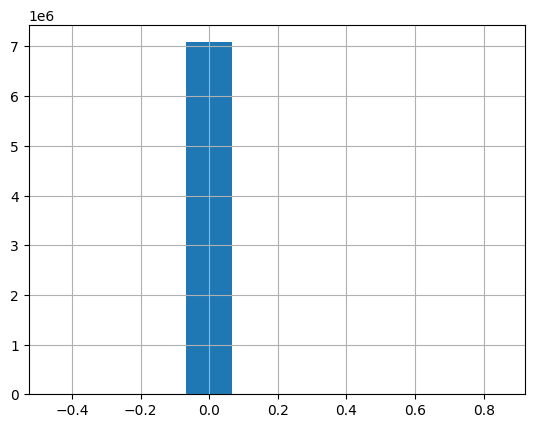

In [ ]:
# Calculate the time difference between consecutive rows in minutes.
bitcoin_cleaned.loc[:, 'time_diff_minutes'] = bitcoin_cleaned.index.to_series().diff().dt.total_seconds() / 60.0

# Calculate percentage change.
bitcoin_cleaned.loc[:, 'pct_change'] = bitcoin_cleaned['close'].pct_change()

# Show the descriptive statistics of percentage change.
print(bitcoin_cleaned['pct_change'].describe())

# Plot the distribution of percentage change.
bitcoin_cleaned['pct_change'].hist()

# Find locations where the time gap is larger than a normal interval (i.e., > 1 minute) and set the pct_change at that point to NaN.
# This neutralizes artifical spikes/crashes produced by deleting a single day of the data from the dataset.
gap_locations = bitcoin_cleaned[bitcoin_cleaned['time_diff_minutes'] > 1.0].index
bitcoin_cleaned.loc[gap_locations, 'pct_change'] = np.nan

In [ ]:
# Calculate the absolute percentage change.
pct_change = bitcoin_cleaned['pct_change'].abs()

# Find the 99.99th percentile.
# That is, 99.99% of all minute-to-minute changes are smaller than this value.
# It's a definition of an extreme outlier.
pct_change_threshold = pct_change.quantile(0.9999)

print(f'The 99.99th percentile for minute-to-minute percentage change is: {pct_change_threshold:.4f}')

The 99.99th percentile for minute-to-minute percentage change is: 0.0446


In [ ]:
# Artificial spikes/crashes from the gap are ignored.
suspicious_pct_change = bitcoin_cleaned[pct_change > pct_change_threshold]
print(f'Found potential errors based on >{pct_change_threshold * 100:.2f}% minute-over-minute change:')
print(suspicious_pct_change[['close', 'volume', 'pct_change']])

Found potential errors based on >4.46% minute-over-minute change:
                        close      volume  pct_change
date                                                 
2012-01-01 20:28:00      4.84   10.000000    0.056769
2012-01-03 16:45:00      5.32    2.419173    0.064000
2012-01-04 09:17:00      4.93    2.320000   -0.068053
2012-01-04 17:41:00      5.19    2.641618    0.052738
2012-01-07 23:14:00      6.80    0.295858    0.133333
...                       ...         ...         ...
2021-07-26 05:01:00  39399.99  222.397677    0.048982
2021-12-04 10:27:00  42431.05  133.645253   -0.051070
2021-12-04 10:28:00  44554.54  289.917692    0.050046
2022-09-21 22:00:00  18788.00  190.668583   -0.047262
2022-11-09 00:34:00  18150.00  128.118250    0.047559

[709 rows x 3 columns]


In [ ]:
# Calculate the spread as a percentage of the open price between the high price and the low price.
bitcoin_cleaned.loc[:, 'intra_minute_spread'] = ((bitcoin_cleaned['high'] - bitcoin_cleaned['low']) / bitcoin_cleaned['open'])

spreads = bitcoin_cleaned['intra_minute_spread'].abs()
spread_threshold = spreads.quantile(0.9999)

print(f'The 99.99th percentile for minute-to-minute spread is: {spread_threshold:.4f}')

# Flag any minute where the price varied by more than threshold.
suspicious_spreads = bitcoin_cleaned[spreads > spread_threshold]

print(f'\nFound potential errors based on >{spread_threshold * 100:.2f}% intra-minute spread:')
print(suspicious_spreads[['open', 'high', 'low', 'close', 'volume', 'intra_minute_spread']])

The 99.99th percentile for minute-to-minute spread is: 0.0507

Found potential errors based on >5.07% intra-minute spread:
                         open      high       low     close      volume  \
date                                                                      
2012-01-13 19:04:00      7.00      7.25      6.86      7.25    5.574967   
2012-01-13 19:06:00      7.35      7.35      6.86      6.86    1.457726   
2012-01-31 22:38:00      5.90      6.00      5.69      6.00   15.870670   
2012-01-31 22:39:00      6.01      6.17      5.69      6.17   24.721214   
2012-02-02 03:06:00      5.55      5.88      5.55      5.88    1.700680   
...                       ...       ...       ...       ...         ...   
2021-10-28 22:38:00  60894.58  60939.38  56559.00  58615.45  209.171524   
2021-12-04 10:27:00  44654.65  44953.41  41967.50  42431.05  133.645253   
2021-12-04 10:28:00  42603.22  45007.36  42107.88  44554.54  289.917692   
2022-01-24 16:10:00  33397.87  38050.00  33385.32  3

/tmp/ipython-input-18-2490888140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned.loc[:, 'intra_minute_spread'] = ((bitcoin_cleaned['high'] - bitcoin_cleaned['low']) / bitcoin_cleaned['open'])


In [ ]:
# Find 5% of all volumes smaller than the threshold.
non_zero_volumes = bitcoin_cleaned[bitcoin_cleaned['volume'] > 0.0]['volume']
low_volume_threshold = non_zero_volumes.quantile(0.05)

print(f'Abnormally low volume threshold (bottom {0.05 * 100}%): {low_volume_threshold:.4f}\n')

Abnormally low volume threshold (bottom 5.0%): 0.0099



In [ ]:
# TODO: Optimization to reduce time.
# Combine the indices of all suspicious rows.
indices_with_anomalies = sorted(list(set(suspicious_pct_change.index) | set(suspicious_spreads.index)))
indices_to_impute = []

# Investigate the flagged points.
for idx in indices_with_anomalies:
  try:
    # Get the integer location of the index.
    loc = bitcoin_cleaned.index.get_loc(idx)
    if loc == 0 or loc == len(bitcoin_cleaned) - 1:
      continue # Skip if it's the first or last row.

    snapshot = bitcoin_cleaned.iloc[loc-1:loc+2, 1:6]

    # Is it a one-minute event (does the price revert)?
    price_t_minus_1 = snapshot.iloc[0]['close']
    price_t = snapshot.iloc[1]['close']
    price_t_plus_1 = snapshot.iloc[2]['close']

    spike_magnitude = abs(price_t - price_t_minus_1)
    reversion_magnitude = abs(price_t - price_t_plus_1)

    is_reverted = (reversion_magnitude / spike_magnitude) > 0.75 if spike_magnitude > 0 else False

    # Is the volume zero or abnormally low?
    volume_t = snapshot.iloc[1]['volume']
    is_volume_zero = (volume_t == 0)
    is_volume_low = (volume_t < low_volume_threshold)

    # Classify each flagged point.
    classification = 'Possible Real Market Event'
    reasons = []

    if is_reverted and (is_volume_zero or is_volume_low):
        classification = 'High Confidence Error'
        reasons.append('Price reverted immediately')
        reasons.append('Volume was zero or abnormally low')
    elif is_reverted:
        classification = 'Likely Error'
        reasons.append('Price reverted immediately')
    elif is_volume_zero or is_volume_low:
        classification = 'Suspicious'
        reasons.append('Volume was zero or abnormally low for a large price move')

    if classification != 'Possible Real Market Event':
      indices_to_impute.append(pd.to_datetime(snapshot.index.values[1]))

    # Print report
    # print(f"--- Investigation Report for Index: {idx} ---")
    # print(snapshot)
    # print("\nAnalysis:")
    # print(f"  - Price Reverted: {is_reverted}")
    # print(f"  - Volume Zero: {is_volume_zero}")
    # print(f"  - Volume Abnormally Low: {is_volume_low}")
    # print(f"  - Classification: **{classification}**")
    # if reasons:
    #     print(f"  - Justification: {', '.join(reasons)}.")
    # print("-" * 60, "\n")

  except Exception as e:
      print(f'Could not process index {idx}. Error: {e}')

In [ ]:
print(bitcoin_cleaned.loc['2012-01-27 06:57:00'])
print(bitcoin_cleaned.loc['2012-01-27 06:58:00'])
print(bitcoin_cleaned.loc['2012-01-27 06:59:00'])

timestamp              1.327647e+09
open                   5.500000e+00
high                   5.500000e+00
low                    5.500000e+00
close                  5.500000e+00
volume                 0.000000e+00
year                   2.012000e+03
hour                   6.000000e+00
is_zero_volume         1.000000e+00
time_diff_minutes      1.000000e+00
pct_change             0.000000e+00
intra_minute_spread    0.000000e+00
Name: 2012-01-27 06:57:00, dtype: float64
timestamp              1.327647e+09
open                   3.800000e+00
high                   3.800000e+00
low                    3.800000e+00
close                  3.800000e+00
volume                 2.700000e-01
year                   2.012000e+03
hour                   6.000000e+00
is_zero_volume         0.000000e+00
time_diff_minutes      1.000000e+00
pct_change            -3.090909e-01
intra_minute_spread    0.000000e+00
Name: 2012-01-27 06:58:00, dtype: float64
timestamp              1.327648e+09
open            

In [ ]:
if indices_to_impute:
    print(f'Found {len(indices_to_impute)} suspicious rows to forward-fill.')
    cols_to_fill = ['open', 'high', 'low', 'close', 'volume'] # Use .loc to select the rows and columns to fill.
    bitcoin_cleaned.loc[indices_to_impute, cols_to_fill] = np.nan # First set to NaN.
    bitcoin_cleaned.loc[:, cols_to_fill] = bitcoin_cleaned[cols_to_fill].ffill() # Then forward-fill.
    print('Imputation complete.')
else:
    print('No suspicious rows found to impute.')

found 334 suspicious rows to forward-fill.
Imputation complete.


In [ ]:
print(bitcoin_cleaned.loc['2012-01-27 06:57:00'])
print(bitcoin_cleaned.loc['2012-01-27 06:58:00'])
print(bitcoin_cleaned.loc['2012-01-27 06:59:00'])

timestamp              1.327647e+09
open                   5.500000e+00
high                   5.500000e+00
low                    5.500000e+00
close                  5.500000e+00
volume                 0.000000e+00
year                   2.012000e+03
hour                   6.000000e+00
is_zero_volume         1.000000e+00
time_diff_minutes      1.000000e+00
pct_change             0.000000e+00
intra_minute_spread    0.000000e+00
Name: 2012-01-27 06:57:00, dtype: float64
timestamp              1.327647e+09
open                   5.500000e+00
high                   5.500000e+00
low                    5.500000e+00
close                  5.500000e+00
volume                 0.000000e+00
year                   2.012000e+03
hour                   6.000000e+00
is_zero_volume         0.000000e+00
time_diff_minutes      1.000000e+00
pct_change            -3.090909e-01
intra_minute_spread    0.000000e+00
Name: 2012-01-27 06:58:00, dtype: float64
timestamp              1.327648e+09
open            

#### 2. Summary Statistics and Distribution Analysis.

##### Descriptive Statistics.

In [ ]:
# Split the full dataset into a training, validation and test set.

In [ ]:
train_set, valid_set, test_set = split_dataset(bitcoin_cleaned)

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5667402 entries, 2012-01-01 10:01:00 to 2022-10-11 02:42:00
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   timestamp            float64
 1   open                 float64
 2   high                 float64
 3   low                  float64
 4   close                float64
 5   volume               float64
 6   year                 int64  
 7   hour                 int64  
 8   is_zero_volume       int64  
 9   time_diff_minutes    float64
 10  pct_change           float64
 11  intra_minute_spread  float64
dtypes: float64(9), int64(3)
memory usage: 562.1 MB


In [ ]:
train_set.describe()

,timestamp,open,high,low,close,volume,year,hour,is_zero_volume,time_diff_minutes,pct_change,intra_minute_spread
count,5.667402e+06,5.667402e+06,5.667402e+06,5.667402e+06,5.667402e+06,5.667402e+06,5.667402e+06,5.667402e+06,5.667402e+06,5667401.0,5.667401e+06,5.667402e+06
mean,1.495434e+09,9.559560e+03,9.565024e+03,9.553893e+03,9.559585e+03,6.222843e+00,2.016896e+03,1.150044e+01,2.227772e-01,1.0,3.472763e-06,1.007723e-03
std,9.816229e+07,1.516878e+04,1.517698e+04,1.516036e+04,1.516890e+04,2.475400e+01,3.110742e+00,6.922252e+00,4.161100e-01,0.0,2.017618e-03,2.119602e-03
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,1.0,-4.604705e-01,0.000000e+00
25%,1.410423e+09,3.146300e+02,3.147700e+02,3.144400e+02,3.146200e+02,1.459317e-02,2.014000e+03,6.000000e+00,0.000000e+00,1.0,-2.369604e-04,0.000000e+00
50%,1.495434e+09,1.991245e+03,1.994900e+03,1.989390e+03,1.991475e+03,6.411307e-01,2.017000e+03,1.200000e+01,0.000000e+00,1.0,0.000000e+00,4.069445e-04
75%,1.580445e+09,9.824795e+03,9.832860e+03,9.817267e+03,9.824990e+03,3.955758e+00,2.020000e+03,1.800000e+01,0.000000e+00,1.0,2.519999e-04,1.282087e-03
max,1.665456e+09,6.900000e+04,6.900000e+04,6.879999e+04,6.900000e+04,5.853852e+03,2.022000e+03,2.300000e+01,1.000000e+00,1.0,8.532000e-01,4.642857e-01


##### Distribution Analysis.

<Axes: >

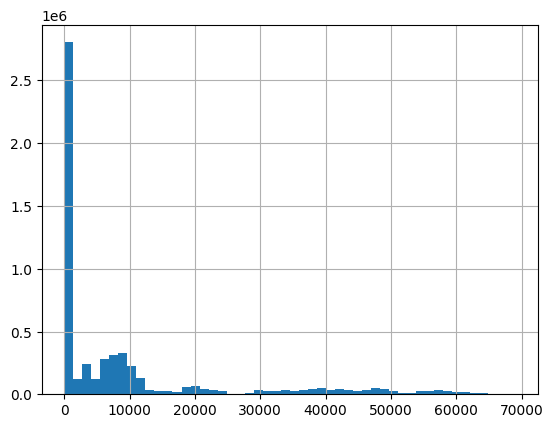

In [ ]:
train_set['close'].hist(bins=50)

<Axes: >

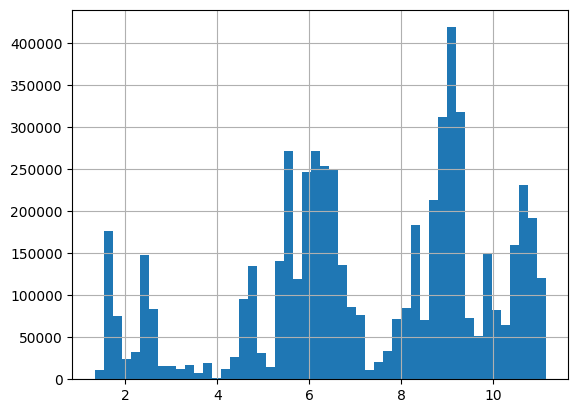

In [ ]:
np.log(train_set['close']).hist(bins=50)

<Axes: >

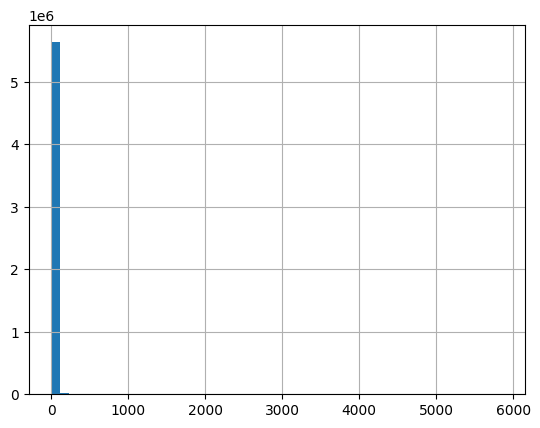

In [ ]:
train_set['volume'].hist(bins=50)

<Axes: >

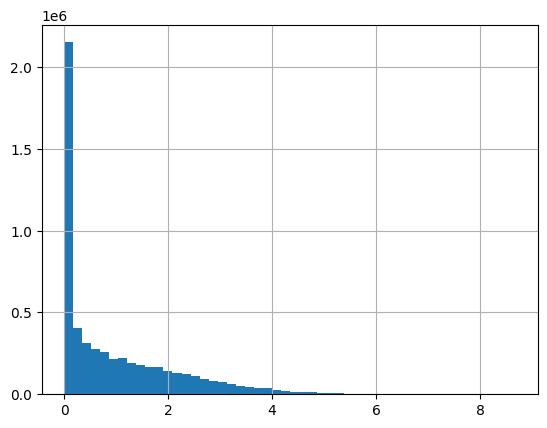

In [ ]:
# Both the trading volume and closing price are heavily right-skewed.
# np.log1p() handles zero division by calculating log(1 + x).
np.log1p(train_set['volume']).hist(bins=50)

<Axes: >

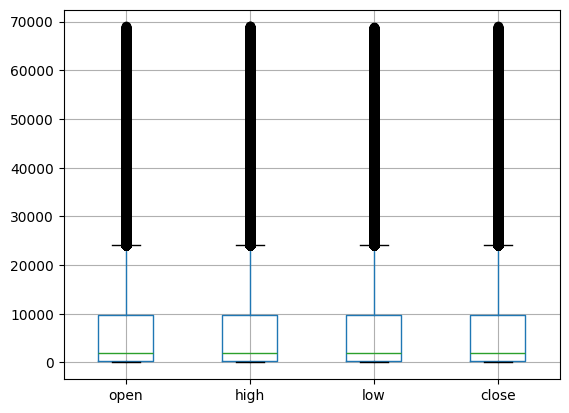

In [ ]:
price_cols = ['open', 'high', 'low', 'close']
train_set[price_cols].boxplot()

<Axes: >

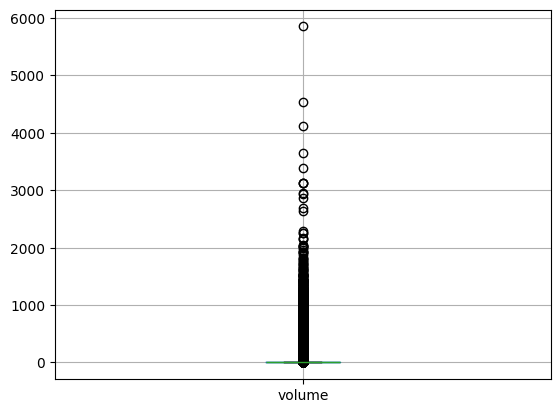

In [ ]:
# Prices and trading volumes have dissimilar scales, so plot them separately.
train_set[['volume']].boxplot()

#### 3. Time-Series Analysis and Visualization.

##### Price and Volume Over Time.

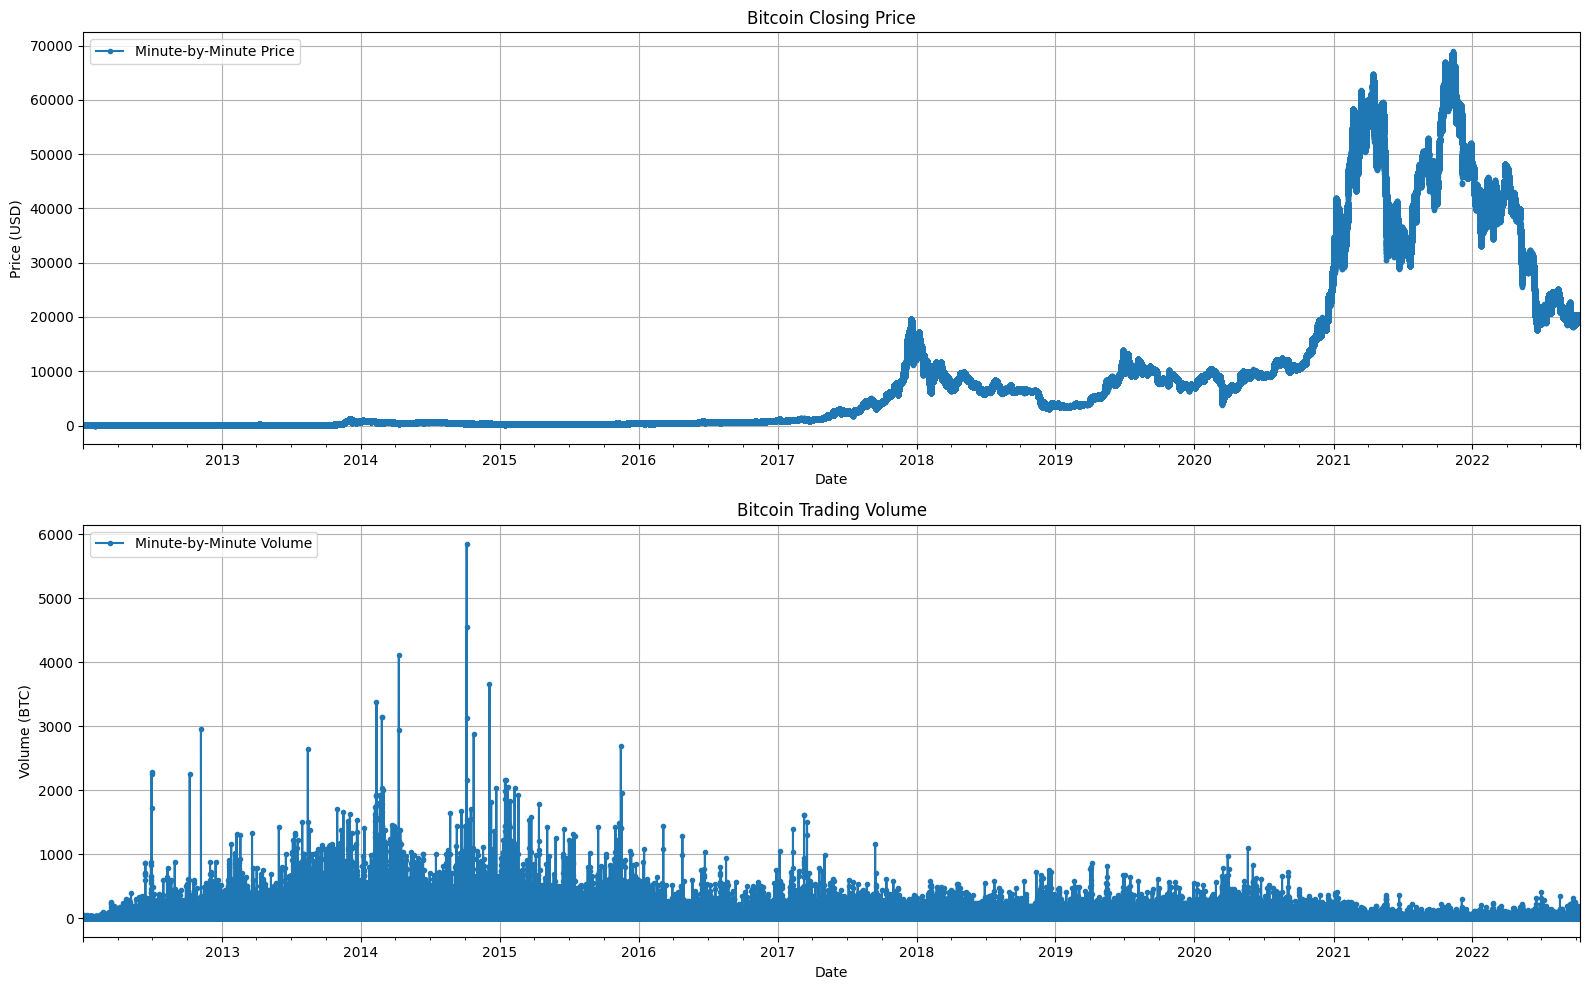

In [ ]:
# Plot price and volume against the same x-axis(time) to see the relationship between the price and trading volume at any point.
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)

train_set['close'].plot(title='Bitcoin Closing Price', label='Minute-by-Minute Price', marker='.')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
train_set['volume'].plot(title='Bitcoin Trading Volume', label='Minute-by-Minute Volume', marker='.')
plt.xlabel('Date')
plt.ylabel('Volume (BTC)')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

##### Resampling and Aggregation.

In [ ]:
bitcoin_ohlcv = resample_and_aggregate_dataset(bitcoin_cleaned)

In [ ]:
bitcoin_daily = bitcoin_ohlcv['daily']

In [ ]:
train_set, valid_set, test_set = split_dataset(bitcoin_daily)

###### Price Trend Analysis.

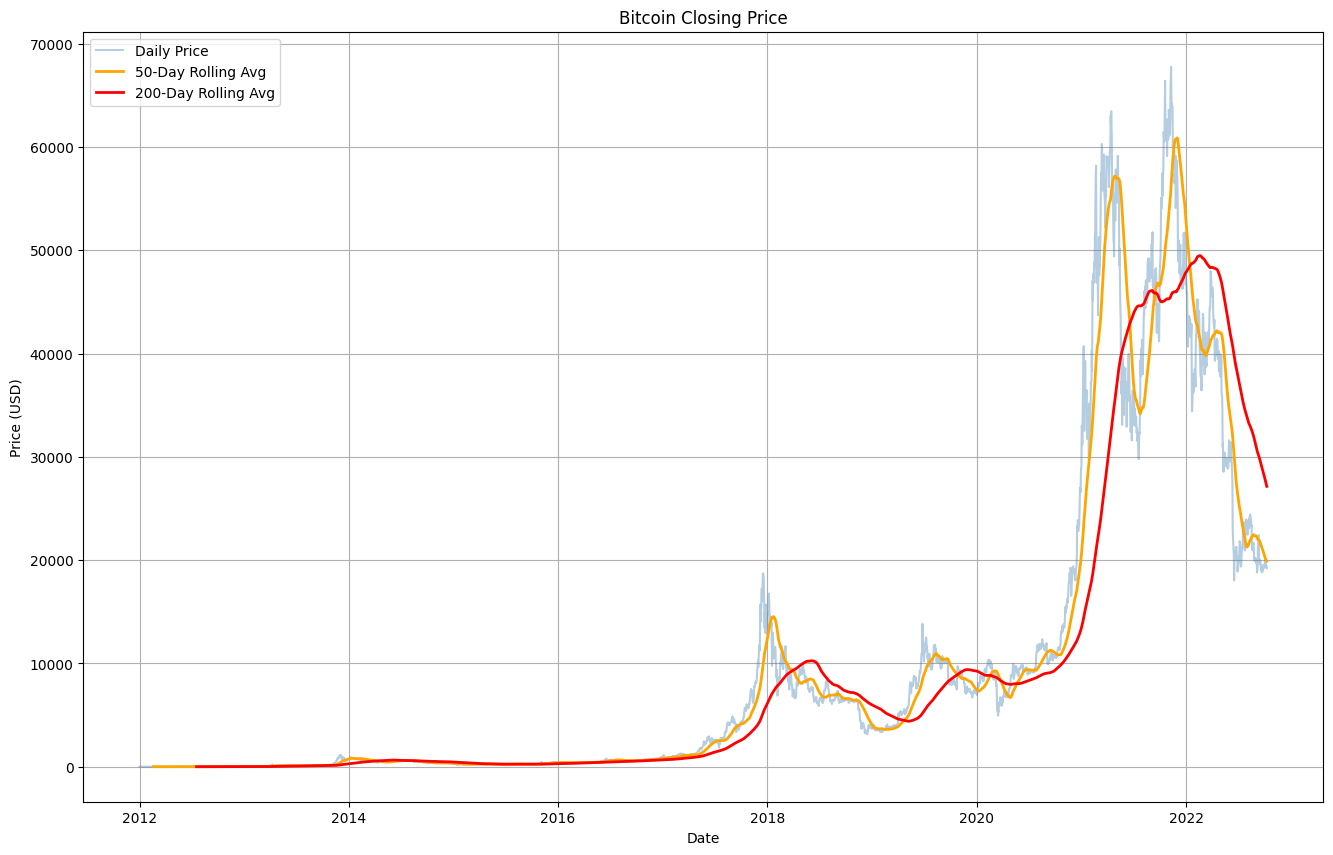

In [ ]:
# Look for patterns of higher highs/lows(uptrend) and lower highs/lows(downtrend)
# Golden Cross(50-day > 200-day -> bullish signal) vs. Death Cross(50-day < 200-day -> bearish signal).
plt.figure(figsize=(16, 10))

plt.plot(train_set.index, train_set['close'], label='Daily Price', alpha=0.4, color='steelblue')
plt.plot(train_set['close'].rolling(window=50).mean(), label='50-Day Rolling Avg', color='orange', linewidth=2)
plt.plot(train_set['close'].rolling(window=200).mean(), label='200-Day Rolling Avg', color='red', linewidth=2)

plt.title('Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Identify the shape and direction of trends of the price.

# Calculate daily log returns. Log calculates percentage change to correctly measure statistical volatility.
train_set['log_return'] = np.log(train_set['close'] / train_set['close'].shift(1))
# Multiply the 30-day rolling standard deviation of these returns by sqrt(365) to annualize it.
train_set['rolling_volatility'] = train_set['log_return'].rolling(window=30).std() * np.sqrt(365)

/tmp/ipython-input-25-3809662450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['log_return'] = np.log(train_set['close'] / train_set['close'].shift(1))
/tmp/ipython-input-25-3809662450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['rolling_volatility'] = train_set['log_return'].rolling(window=30).std() * np.sqrt(365)


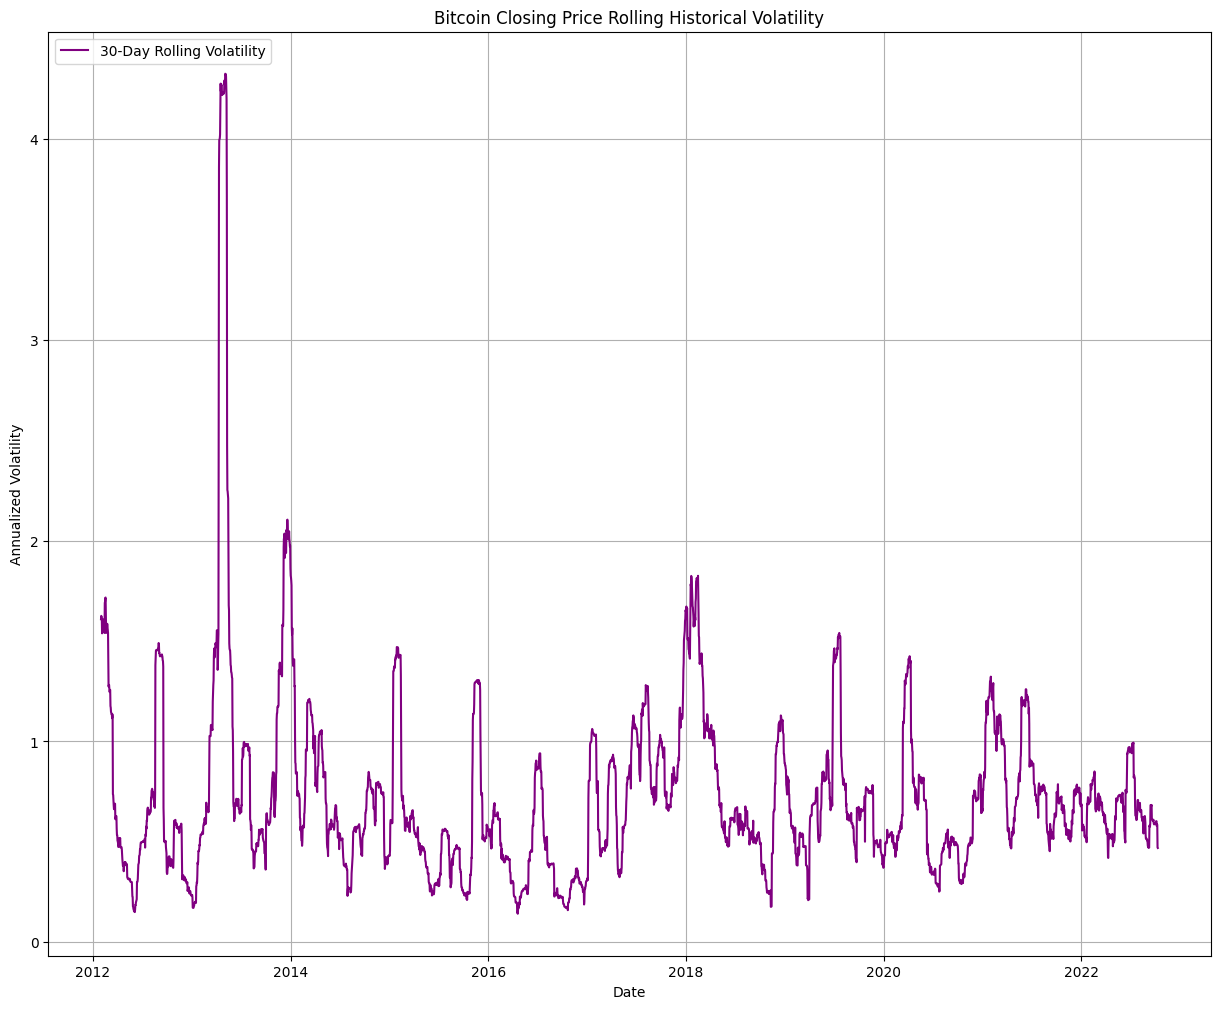

In [ ]:
plt.figure(figsize=(15, 12))

plt.title('Bitcoin Closing Price Rolling Historical Volatility')
plt.plot(train_set.index, train_set['rolling_volatility'], label='30-Day Rolling Volatility', color='purple')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

###### Volume Trend Analysis.


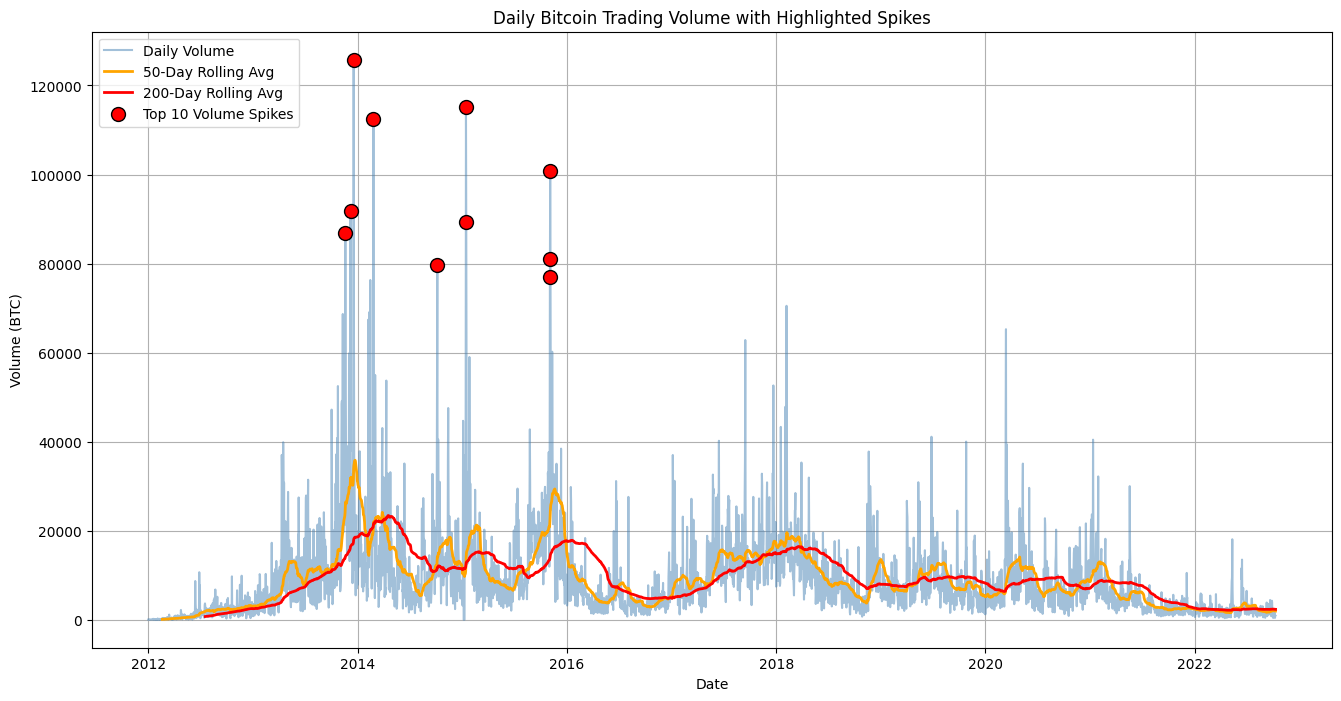

In [ ]:
# Look for the overall long-term trend of the trading volume an find volume spikes.
plt.figure(figsize=(16, 8))

plt.plot(train_set.index, train_set['volume'], label='Daily Volume', alpha=0.5, color='steelblue')
plt.plot(train_set['volume'].rolling(window=50).mean(), label='50-Day Rolling Avg', color='orange', linewidth=2)
plt.plot(train_set['volume'].rolling(window=200).mean(), label='200-Day Rolling Avg', color='red', linewidth=2)

top_10_daily_volume_spikes = train_set.sort_values('volume', ascending=False).head(10)

plt.scatter(
    top_10_daily_volume_spikes.index,
    top_10_daily_volume_spikes['volume'],
    color='red',
    s=100,
    edgecolor='black',
    label='Top 10 Volume Spikes',
    zorder=5
)

plt.title('Daily Bitcoin Trading Volume with Highlighted Spikes')
plt.xlabel('Date')
plt.ylabel('Volume (BTC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

###### Relationship Between Price and Volume.

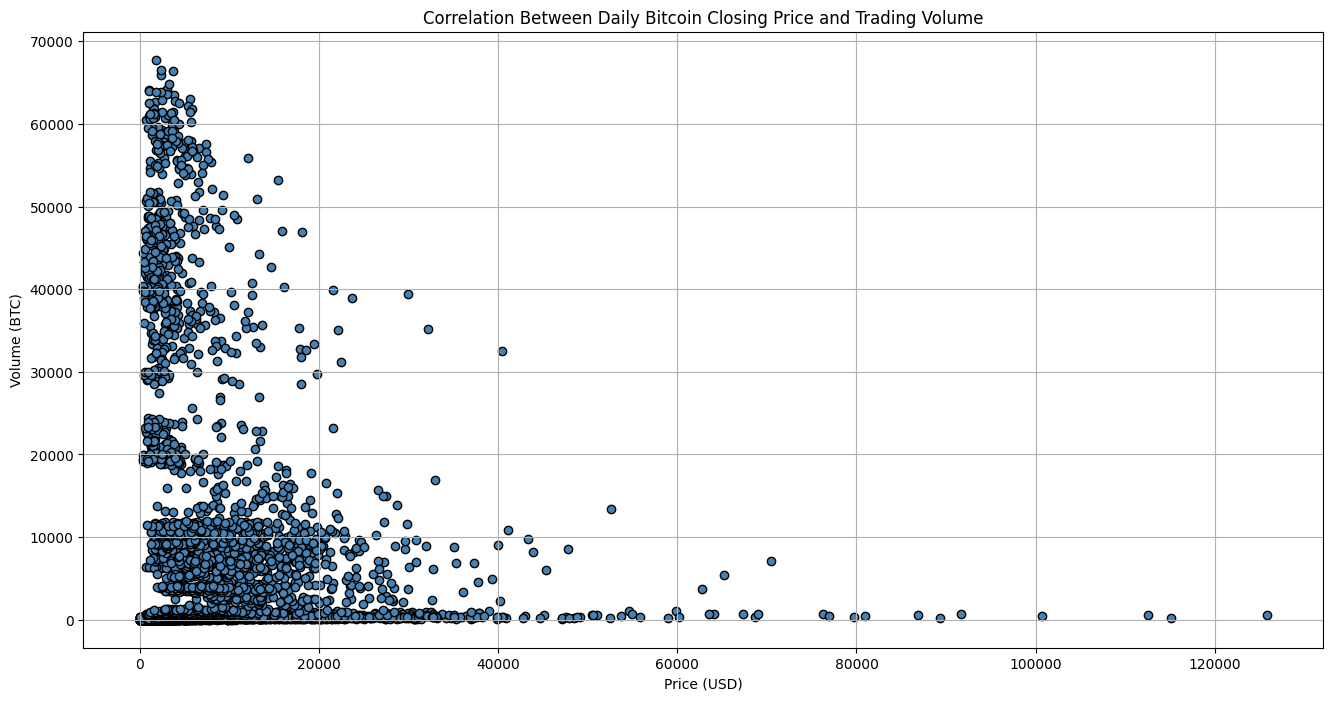

In [ ]:
# Identify the relationship between price and trading volume to confirm trends(uptrend/downtrend).
plt.figure(figsize=(16, 8))

plt.scatter(
    train_set['volume'],
    train_set['close'],
    color='steelblue',
    edgecolor='black',
)

plt.title('Correlation Between Daily Bitcoin Closing Price and Trading Volume')
plt.xlabel('Price (USD)')
plt.ylabel('Volume (BTC)')
plt.grid(True)
plt.show()

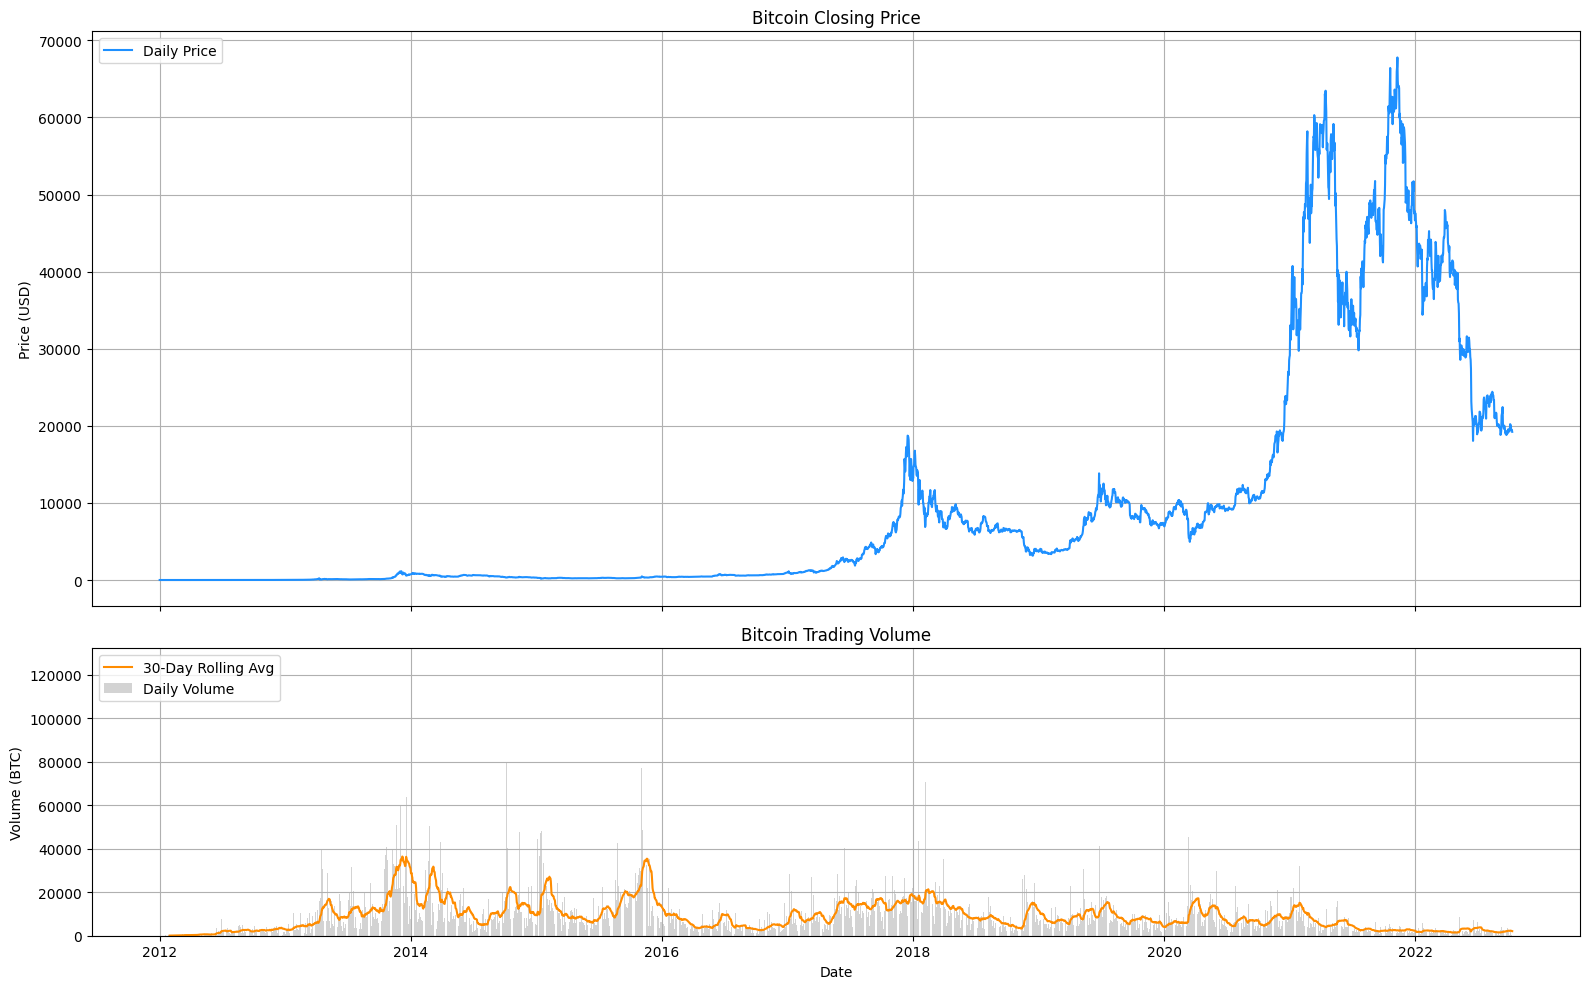

In [ ]:
# Find a trend divergence between the closing price and trading volume.
# Bearish Divergence(prices reach a new high on lower volume than the previous high) vs. Bullish Divergence(prices reach a new low on lower volume than the previous low)
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(16, 10),
    sharex=True,
    gridspec_kw={'height_ratios': [2, 1]}
)

ax1.set_title('Bitcoin Closing Price')
ax1.plot(train_set.index, train_set['close'], label='Daily Price', color='dodgerblue')
ax1.set_ylabel('Price (USD)')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.set_title('Bitcoin Trading Volume')
ax2.bar(train_set.index, train_set['volume'], label='Daily Volume', color='lightgray')

# Add a moving average to the volume to see its trend more clearly.
volume_ra_daily = train_set['volume'].rolling(window=30).mean()
ax2.plot(volume_ra_daily.index, volume_ra_daily, label='30-Day Rolling Avg', color='darkorange')

ax2.set_ylabel('Volume (BTC)')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Copy the cleaned dataset to data/cleaned.

In [ ]:
bitcoin_cleaned.loc[:, 'date'] = pd.to_datetime(bitcoin_cleaned['timestamp'], unit='s') # Saving a dataset to a CSV file does not retain the index.
bitcoin_cleaned.to_csv(CSV_CLEANED, index=False)

shutil.copy(f'/content/{CSV_CLEANED}', cleaned_filepath)

/tmp/ipython-input-41-2996435672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned['date'] = pd.to_datetime(bitcoin_cleaned['timestamp'], unit='s') # Saving a dataset to a CSV file does not retain the index.


PosixPath('/content/drive/MyDrive/projects/bitcoin/data/cleaned/bitcoin_274_cleaned.csv')

In [ ]:
bitcoin_cleaned.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'year', 'hour',
       'is_zero_volume', 'time_diff_minutes', 'pct_change',
       'intra_minute_spread', 'date'],
      dtype='object')

#### 4. Trend, Seasonality, and Cyclicality.

In [ ]:
bitcoin_cleaned = pd.read_csv(cleaned_filepath,
                              index_col='date',
                              parse_dates=['date'])

In [ ]:
bitcoin_cleaned.head()

,timestamp,open,high,low,close,volume,year,hour,is_zero_volume,time_diff_minutes,pct_change,intra_minute_spread
date,,,,,,,,,,,,
2012-01-01 10:01:00,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012,10,1,NaN,NaN,0.0
2012-01-01 10:02:00,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012,10,1,1.0,0.0,0.0
2012-01-01 10:03:00,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012,10,1,1.0,0.0,0.0
2012-01-01 10:04:00,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012,10,1,1.0,0.0,0.0
2012-01-01 10:05:00,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012,10,1,1.0,0.0,0.0


In [ ]:
bitcoin_cleaned.index

DatetimeIndex(['2012-01-01 10:01:00', '2012-01-01 10:02:00',
               '2012-01-01 10:03:00', '2012-01-01 10:04:00',
               '2012-01-01 10:05:00', '2012-01-01 10:06:00',
               '2012-01-01 10:07:00', '2012-01-01 10:08:00',
               '2012-01-01 10:09:00', '2012-01-01 10:10:00',
               ...
               '2025-06-22 00:44:00', '2025-06-22 00:45:00',
               '2025-06-22 00:46:00', '2025-06-22 00:47:00',
               '2025-06-22 00:48:00', '2025-06-22 00:49:00',
               '2025-06-22 00:50:00', '2025-06-22 00:51:00',
               '2025-06-22 00:52:00', '2025-06-22 00:53:00'],
              dtype='datetime64[ns]', name='date', length=7084253, freq=None)

In [ ]:
bitcoin_ohlcv = resample_and_aggregate_dataset(bitcoin_cleaned)

In [ ]:
bitcoin_daily = bitcoin_ohlcv['daily']

In [ ]:
train_set, valid_set, test_set = split_dataset(bitcoin_daily)

##### Time-Series Decomposition.

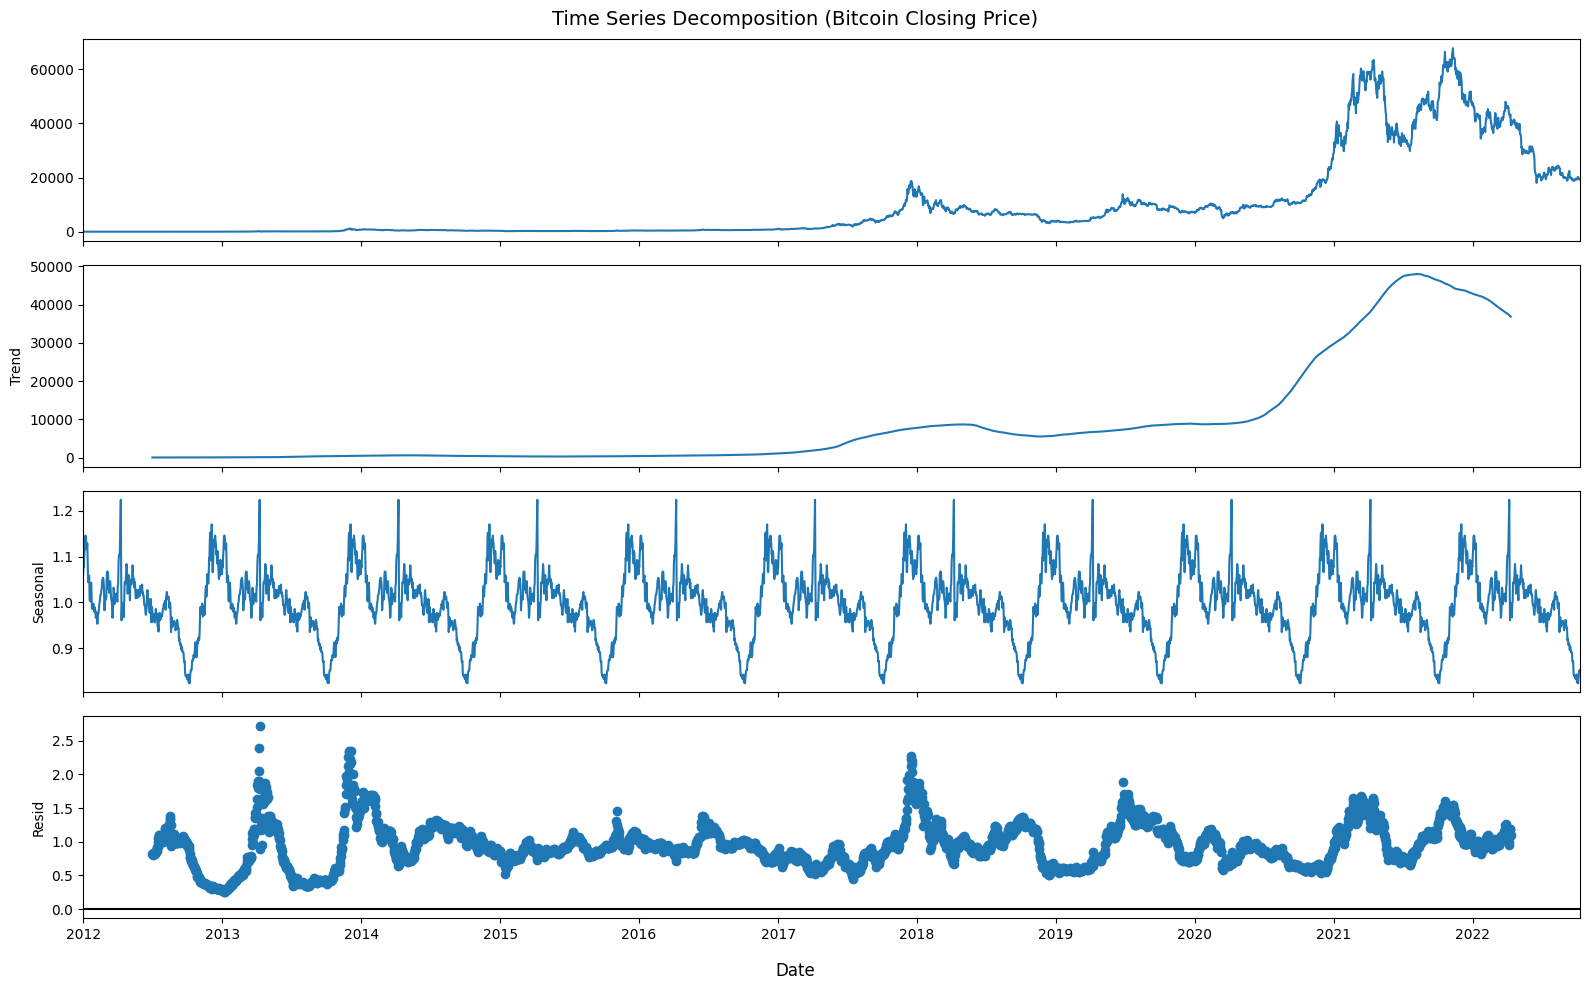

In [ ]:
# Break the time series down into core components(trend, seasonality and residuals) to see the underlying structure.
decomposition = seasonal_decompose(train_set['close'], model='multiplicative', period=365) # Assuming yearly seasonality.

fig = decomposition.plot()
fig.set_size_inches(16, 10)
fig.supxlabel('Date')
fig.suptitle('Time Series Decomposition (Bitcoin Closing Price)', fontsize=14)
for ax in fig.get_axes():
    ax.set_title('')
fig.tight_layout()
fig.show()

##### Autocorrelation Analysis (ACF & PACF).

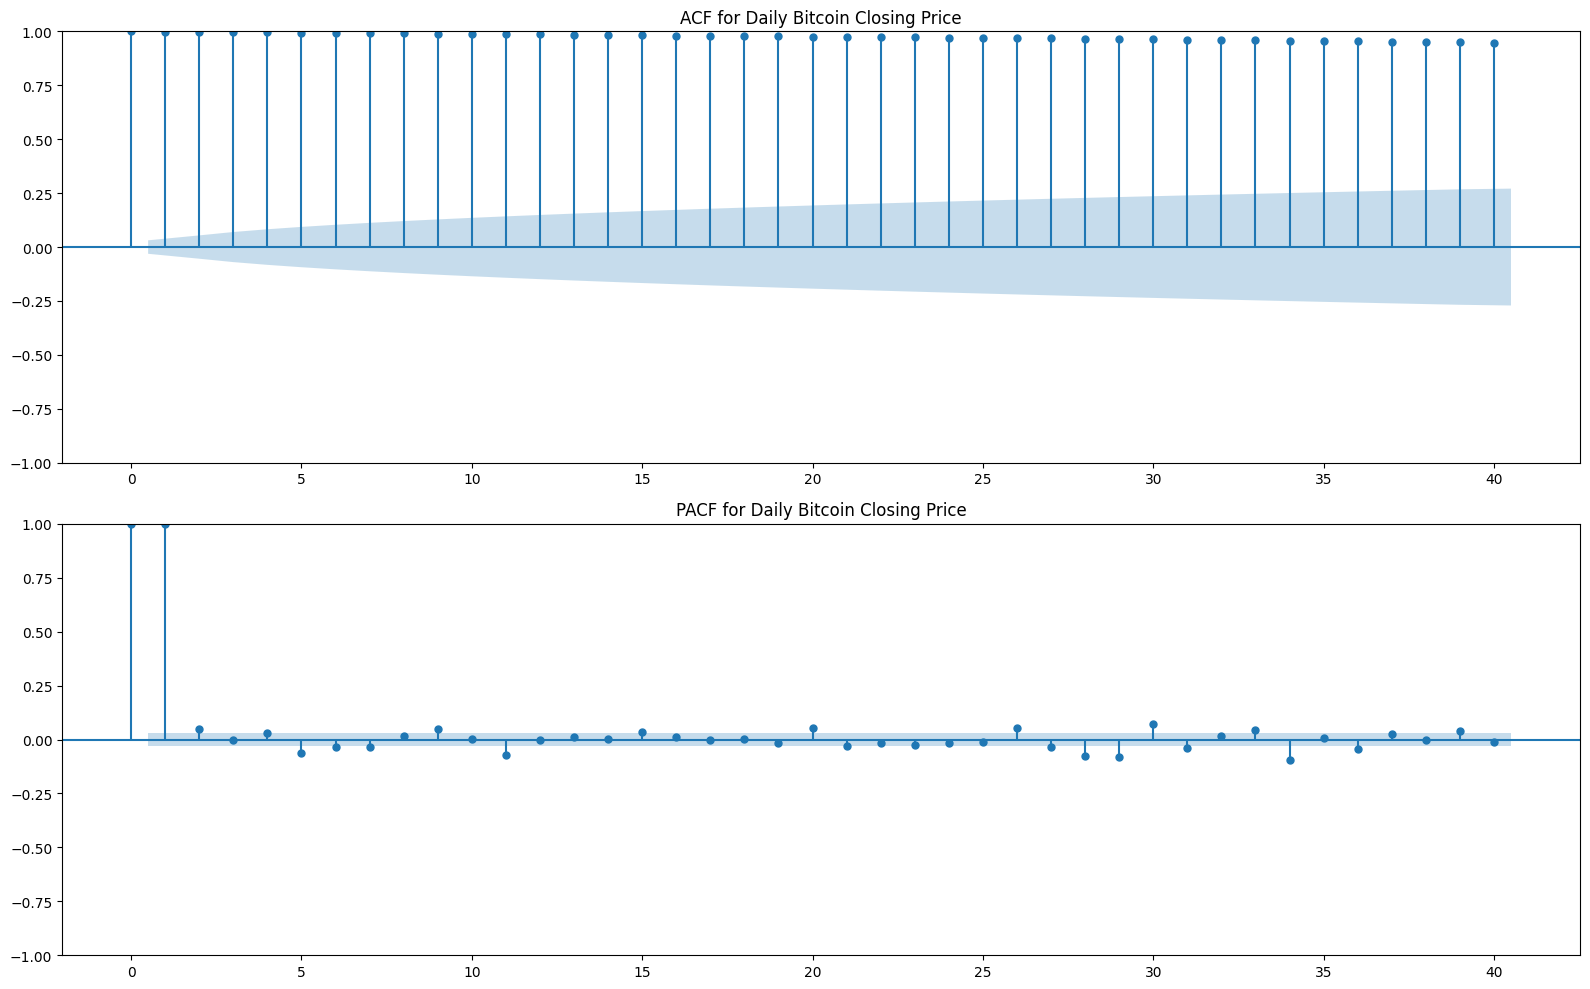

In [ ]:
# Autocorreleation describes how a time series data point relates to its past values.
# ACF and PACF plots are crucial for identifying the presence/strength of seasonality and for determining the parameters of time-series models.
# ACF plots show the correlation of the time series with lags.
# PACF plots show the correlation of the time series with lags but with the intervening correlations removed.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_acf(train_set['close'], lags=40, ax=ax1)
ax1.set_title('ACF for Daily Bitcoin Closing Price')

plot_pacf(train_set['close'], lags=40, ax=ax2)
ax2.set_title('PACF for Daily Bitcoin Closing Price')

plt.tight_layout()
plt.show()

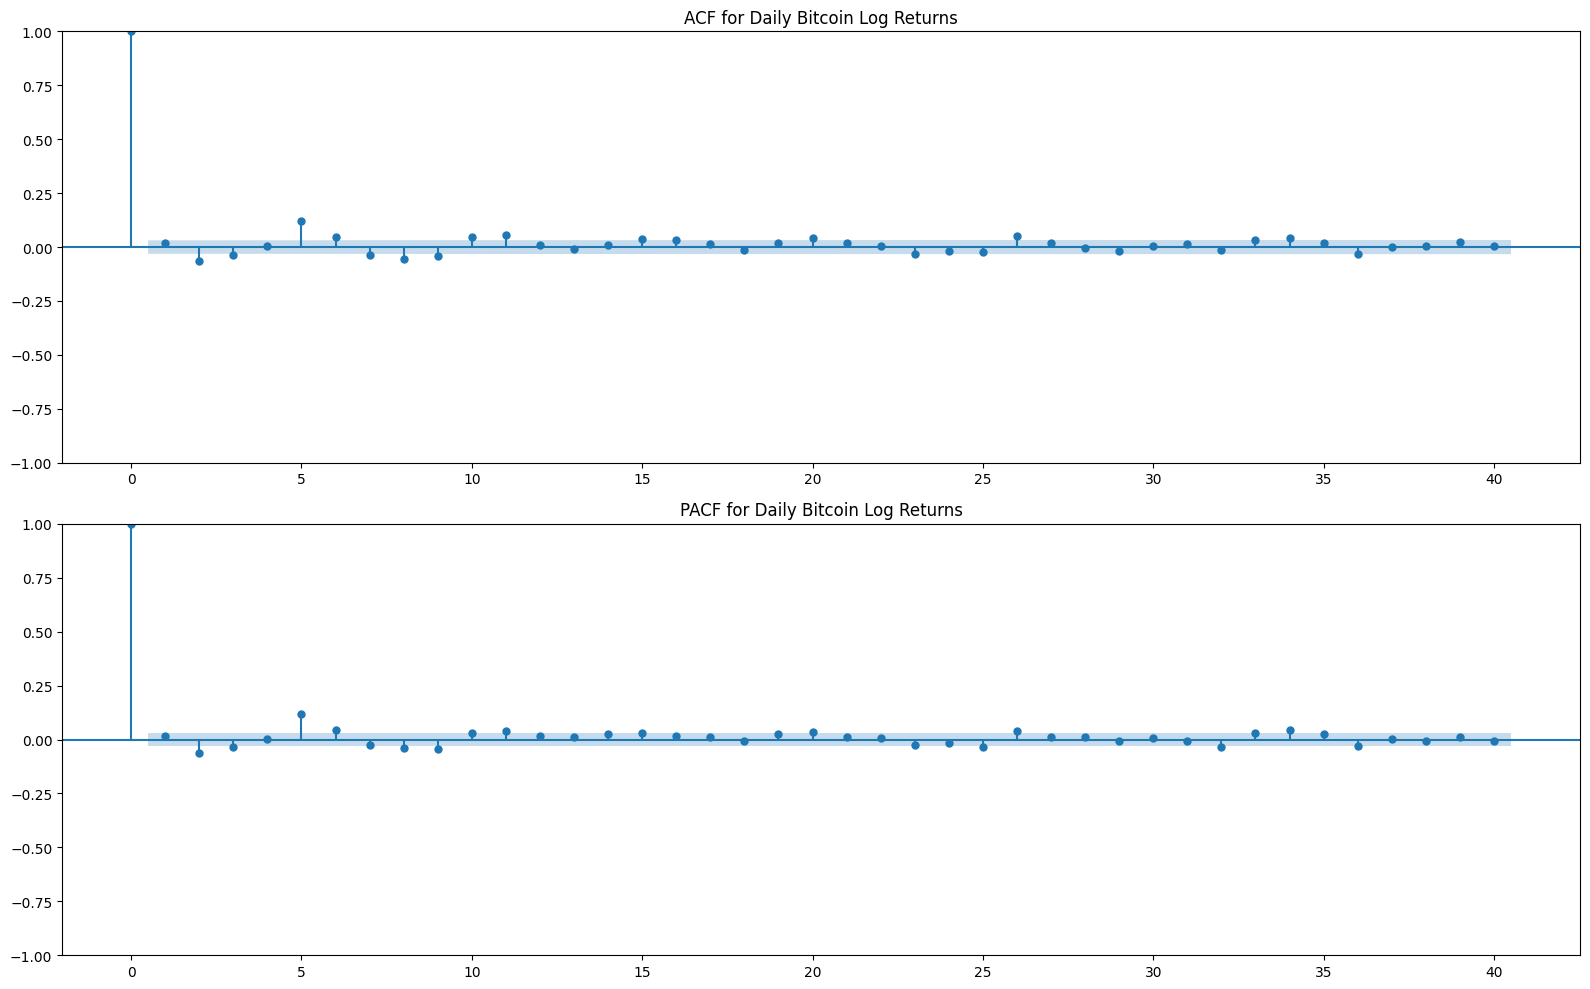

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_acf(train_set['log_return'].dropna(), lags=40, ax=ax1)
ax1.set_title('ACF for Daily Bitcoin Log Returns')

plot_pacf(train_set['log_return'].dropna(), lags=40, ax=ax2)
ax2.set_title('PACF for Daily Bitcoin Log Returns')

plt.tight_layout()
plt.show()

##### Stationarity Analysis (ADF Test).

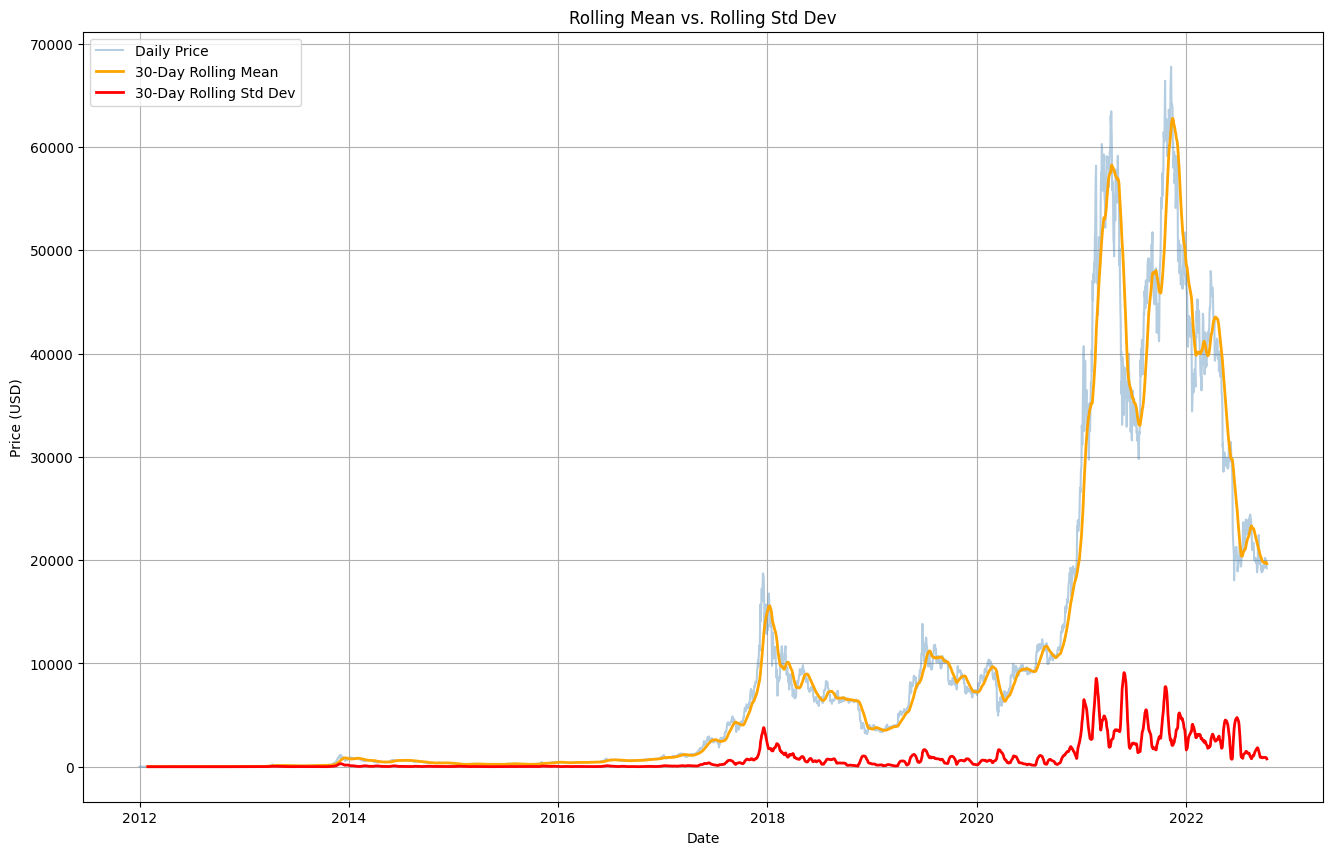

In [ ]:
plt.figure(figsize=(16, 10))

plt.plot(train_set.index, train_set['close'], label='Daily Price', alpha=0.4, color='steelblue')
plt.plot(train_set['close'].rolling(window=30).mean(), label='30-Day Rolling Mean', color='orange', linewidth=2)
plt.plot(train_set['close'].rolling(window=30).std(), label='30-Day Rolling Std Dev', color='red', linewidth=2)

plt.title('Rolling Mean vs. Rolling Std Dev')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# ADF test is a formal statistical way to test for stationarity.
# Null Hypothesis: The time series is non-stationary.
# The p-value bigger than 0.05 represents non-stationarity whereas the p-value less than 0.05 stands for stationarity.
def perform_adf_test(series, series_name):
  print(f'--- Augmented Dickey-Fuller Test for "{series_name}" ---')

  result = adfuller(series.dropna())

  print(f'ADF Statistics: {result[0]:.4f}')
  print(f'p-value: {result[1]:.4f}')
  print('Critical Values:')
  for key, value in result[4].items():
    print(f'\t{key}:{value:.4f}')

  if result[1] <= 0.05:
    print('\nConclusion: Strong evidence against the null hypothesis.')
    print('The series is likely STATIONARY.')
  else:
    print('\nConclusion: Weak evidence against the null hypothesis.')
    print('The series is likely NON-STATIONARY.')
  print('-' * 62, '\n')

In [ ]:
perform_adf_test(train_set['close'], 'Daily Bitcoin Closing Price')
train_set['log_return'] = np.log(train_set['close'] / train_set['close'].shift(1))
perform_adf_test(train_set['log_return'], 'Daily Bitcoin Log Returns')

--- Augmented Dickey-Fuller Test for "Daily Bitcoin Closing Price" ---
ADF Statistics: -1.7223
p-value: 0.4197
Critical Values:
	1%:-3.4320
	5%:-2.8623
	10%:-2.5672

Conclusion: Weak evidence against the null hypothesis.
The series is likely NON-STATIONARY.
-------------------------------------------------------------- 

--- Augmented Dickey-Fuller Test for "Daily Bitcoin Log Returns" ---


/tmp/ipython-input-36-633732974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['log_return'] = np.log(train_set['close'] / train_set['close'].shift(1))


ADF Statistics: -10.8444
p-value: 0.0000
Critical Values:
	1%:-3.4320
	5%:-2.8623
	10%:-2.5672

Conclusion: Strong evidence against the null hypothesis.
The series is likely STATIONARY.
-------------------------------------------------------------- 

